<a href="https://colab.research.google.com/github/DSookarah/CE888/blob/main/Lab_3/bank_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1LWhyLMSJmdYm1R8QfVO3Lj_te4E5uxtY?usp=sharing)

In [1]:
import sklearn
import pandas as pd # Allow us to work with CSV files
import numpy as np # Allow us to work with arrays
from sklearn.preprocessing import LabelEncoder # Allow us to encode each target label with values between 0 and n_classes-1
import seaborn as sns # Import Seaborn visualization library
from sklearn.model_selection import train_test_split # Import train_test_split function
import matplotlib.pyplot as plt # Allow us to customize histograms
from sklearn.ensemble import RandomForestClassifier # Import random forest classifier
from sklearn.tree import DecisionTreeClassifier # Import decision tree classifier
from sklearn.model_selection import StratifiedKFold, cross_val_score # Import stratified K-Folds cross-validator and cross validation score
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, f1_score # Import scikit-learn.metrics module for accuracy score, make_scorer and confusion matrix
import warnings
warnings.filterwarnings('ignore') # Allow to disable Python warnings

In [2]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [3]:
# Step 1: Loading "bank-additional-full.csv" csv file

dataset_bank = pd.read_csv("https://raw.githubusercontent.com/albanda/CE888/master/lab3/bank-additional-full.csv", delimiter = ";") # Read a CSV file from internet (Github) that contains a custom delimeter (;)
print('"bank-additional-full" dataset (All rows)')
display(dataset_bank)                                      # Print the "bank-additional-full" dataset (truncated)
print('\n"bank-additional-full" dataset (First 10 rows)')
display(dataset_bank[0:10])                                # Print the first 50 rows of "bank-additional-full" dataset

"bank-additional-full" dataset (All rows)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes



"bank-additional-full" dataset (First 10 rows)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,198,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,139,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,217,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,380,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,50,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
# Step 2: Handling categorical data

dataset_bank_objects = dataset_bank.dtypes[dataset_bank.dtypes == np.object] # Get only the columns that are "Object" data-type from "bank-additional-full" dataset
names_dataset_bank_objects = list(dataset_bank_objects.index)                # Get the names of the columns that are "Object" data-type from "bank-additional-full" dataset
dataset_bank_lenc = dataset_bank.copy()                                      # Create a copy of "bank-additional-full" dataset

print('''\nData-types of "bank-additional-full" dataset:

%s   

As we can see above, the following columns are categorical and need to be encoded:

%s
'''%(dataset_bank.dtypes, dataset_bank_objects))  # Output: All data-type from "bank-additional-full" dataset. 

# Performing Label encoding to categorical data.
for x in names_dataset_bank_objects:                     # For-loop iterates over the values found in columns that are "Object" data-type from "bank-additional-full" dataset
  dataset_bank_lenc[[x]] = dataset_bank_lenc[[x]].apply(LabelEncoder().fit_transform) # Transforming categorical data with LabelEncoder instance.

print('\n"bank-additional-full" dataset (original)(First 10 rows)')
display(dataset_bank[0:10])                                                        # Print the first 10 rows of "bank-additional-full" dataset

print('\n"bank-additional-full" dataset (after label encoding)(First 10 rows)')
display(dataset_bank_lenc[0:10])                                                   # Print the first 10 rows of "bank-additional-full" dataset after label encoding

# Label Enconding      This approach is very simple and it involves converting each categorical value in a column to a number.
# .dtypes              This function is used to find the data-type in the dataframe.
#                      If [dtypes == np.object], it will find only the data-type that is object.
# list(.index)         This function is used to get the names of the columns in a dataframe
# .copy()              This function is used to make a copy of one dataframe with indices and data


Data-types of "bank-additional-full" dataset:

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object   

As we can see above, the following columns are categorical and need to be encoded:

job            object
marital        object
education      object
default        object
housing        object
loan           object
contact        object
month          object
day_of_week    object
poutcome       object
y              object
dtype: object


"bank-additional-full" dataset (original)(Firs

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,198,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,139,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,217,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,380,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,50,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no



"bank-additional-full" dataset (after label encoding)(First 10 rows)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,3,1,0,0,0,0,1,6,1,261,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
1,57,7,1,3,1,0,0,1,6,1,149,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
2,37,7,1,3,0,2,0,1,6,1,226,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
3,40,0,1,1,0,0,0,1,6,1,151,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
4,56,7,1,3,0,0,2,1,6,1,307,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
5,45,7,1,2,1,0,0,1,6,1,198,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
6,59,0,1,5,0,0,0,1,6,1,139,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
7,41,1,1,7,1,0,0,1,6,1,217,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
8,24,9,2,5,0,2,0,1,6,1,380,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
9,25,7,2,3,0,2,0,1,6,1,50,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0


In [5]:
# Step 3: Finding missing values

print('''\nAs we can see below, there is no missing values in the "bank-additional-full" dataset.

%s''' %(dataset_bank_lenc.isnull().sum()))   # Output: One table showing the total of missing values (nan) for each column in the given dataset

# Step 4: Dropping Column "duration"
print('\n"bank-additional-full" dataset (After label encoding)(First 10 rows)')
display(dataset_bank_lenc[0:10])                                                  # Print the first 10 rows of "bank-additional-full" dataset

dataset_bank_lenc_dropdur = dataset_bank_lenc.drop(columns='duration')  # Drop the column "duration"

print('\n"bank-additional-full" dataset (After label encoding and dropping column "duration")(First 10 rows)')
display(dataset_bank_lenc_dropdur[0:10])                                           # Print the first 10 rows of "bank-additional-full" dataset after label encoding and dropping column "duration"

# isnull().sum()     This function is used to sum the rows with missing values for each column in the given dataset. 
# .drop(columns='')  This function is used to delete 1 specific column


As we can see below, there is no missing values in the "bank-additional-full" dataset.

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

"bank-additional-full" dataset (After label encoding)(First 10 rows)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,3,1,0,0,0,0,1,6,1,261,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
1,57,7,1,3,1,0,0,1,6,1,149,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
2,37,7,1,3,0,2,0,1,6,1,226,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
3,40,0,1,1,0,0,0,1,6,1,151,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
4,56,7,1,3,0,0,2,1,6,1,307,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
5,45,7,1,2,1,0,0,1,6,1,198,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
6,59,0,1,5,0,0,0,1,6,1,139,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
7,41,1,1,7,1,0,0,1,6,1,217,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
8,24,9,2,5,0,2,0,1,6,1,380,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
9,25,7,2,3,0,2,0,1,6,1,50,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0



"bank-additional-full" dataset (After label encoding and dropping column "duration")(First 10 rows)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,3,1,0,0,0,0,1,6,1,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
1,57,7,1,3,1,0,0,1,6,1,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
2,37,7,1,3,0,2,0,1,6,1,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
3,40,0,1,1,0,0,0,1,6,1,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
4,56,7,1,3,0,0,2,1,6,1,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
5,45,7,1,2,1,0,0,1,6,1,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
6,59,0,1,5,0,0,0,1,6,1,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
7,41,1,1,7,1,0,0,1,6,1,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
8,24,9,2,5,0,2,0,1,6,1,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
9,25,7,2,3,0,2,0,1,6,1,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0


These are the feature variables (X):
['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome']

This is the target variable (Y):
['y']

Frequency distribution of target "y":
y
0    36548
1     4640
dtype: int64



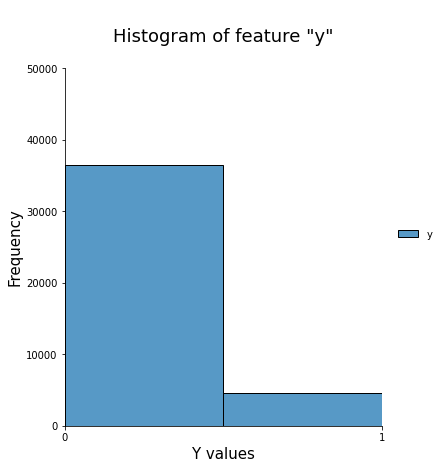

In [6]:
# Step 5: Splitting the dataset in feature variables (independent variables) and target variable (dependent Variable)

features_name_list = dataset_bank_lenc_dropdur.columns.to_list() # Get the names of the columns of "bank-additional-full" dataset after label encoding and dropping column "duration"

X = features_name_list[:14] # This feature variable will exclude "duration" feature (dropped) and target variable ("y")
print ('''These are the feature variables (X):
%s\n''' %(X))

Y = features_name_list[-1:] # This target variable will include only the last element in a list ("y")
print ('''This is the target variable (Y):
%s\n''' %(Y))

# Step 6: Plotting a histogram of the target variable and calculating the imbalance in the dataset
y_hist = dataset_bank_lenc_dropdur[Y]     # Retrieve all values of the column "y"
y_hist_count = dataset_bank_lenc_dropdur[Y].value_counts()  # Count unique values of column "y"

print ('''Frequency distribution of target "y":
%s\n''' %(y_hist_count))

plot_yhist = sns.displot(y_hist, bins = 2, kde = False, height=5.5, aspect=1)  # Creates a histogram with the specified parameters.
plot_yhist.axes[0, 0].set_xlim(0,1)                                            # This X-Axis property indicates: "Start at 0, finish at 1"
plot_yhist.axes[0, 0].set_ylim(0,50000)                                        # This Y-Axis property indicates: "Start at 0, finish at 50000"
plot_yhist.set(xticks=np.arange(0, 2, 1))                                      # This X-Axis property allows us to show specific values on the X-axis (Start at 0, finish at 2 and counting up in steps of 1)
plt.xlabel("Y values", fontsize=15)                                            # Add and customize X-Axis label
plt.ylabel("Frequency", fontsize=15)                                           # Add and customize Y-Axis label
plt.title('\nHistogram of feature "y"\n', fontsize=18)                     # Add a title to the histogram
plt.show()   # Display the current figure that you are working on

# df.value_counts()     This function is used to count unique values of a dataset
# sns.displot           This function represents the histogram, which combines the matplotlib hist function with the seaborn kdeplot() function.
# height                This parameter is the height of each facet (in inches). [Height = 5] is a good value to increase the size of the histogram. 
# aspect                This parameter is the aspect ratio of each facet.
#                       The width of each facet is calculated by doing [aspect * height]
# bins                  This parameter is used to specify the number of bins in the histogram. 
# kde = False           This parameter is used to NOT plot a Gaussian-kernel density estimate.

**Intepretation**<br>
It can be concluded that this dataset is very imbalanced, since 88% of the values of "y" column are "No" (0)

In [7]:
# Step 7: Splitting the dataset into training set and testing set with Kfold stratification

target = dataset_bank_lenc_dropdur.loc[:,Y]           # This array contains ONLY the target variable values.
print('\nValues of Column "y" (target variable)')     # Output: Target variable dataset
display(target)
print('')

# Splitting "dataset_bank_lenc_dropdur" into training Set (Ratio 88/11) and testing set (Ratio 88/11). (This is the same ratio as the original dataset)
print('Ratio for each fold:\n')
skf = StratifiedKFold(n_splits=10, shuffle = True)                                # Create the StratifiedKFold object. The number of splits is equal to 10, because the lab 3 requires 10-fold stratified cross-validation
fold_no = 1                                                                       # fold_no is initially 1.
for train_index, test_index in skf.split(dataset_bank_lenc_dropdur, target):      # For-loop iterates over the values found in "dataset_bank_lenc_dropdur" (feature variables dataset) and "target" (target variable dataset). In other words, it gets the train and test row indexes for each split
  train = dataset_bank_lenc_dropdur.loc[train_index,:]                            # Output: How many samples does the training set contain (Target dataset: 88% of "no" & 12% of "yes")
  test = dataset_bank_lenc_dropdur.loc[test_index,:]                              # Output: How many samples does the testing set contain  (Target dataset: 88% of "no" & 12% of "yes")
  print('\033[1m'+'Fold '+str(fold_no)+' Class Ratio:'+'\033[0m'+' %s'%("{:.8%}".format(sum(test['y'])/len(test['y'])))) # Print the target ratio for each fold to check if they are all close to the full dataset (11.26% of "yes").
  
  # Uncomment the following line if you want to see the training set for each fold created (Target dataset: 88% of "no" & 12% of "yes")
  #display(train)
  
  # Uncomment the following line if you want to see the testing set for each fold created (Target dataset: 88% of "no" & 12% of "yes")
  #display(test)                                                                   
  fold_no += 1       # Output: fold_no = [fold_no + 1](increments 1 on each loop)

# DataFrame.loc       This attribute access a group of rows and columns by label(s) or a boolean array in the given dataframe.
#                     .loc[:,Y] indicates: "get all the rows of columns found in variable "y"
# sfk.split()         This function is used to return a list of strings separated by columns. 
# Code '\033[1m' and '\033[0m' allow to print a string in bold.


Values of Column "y" (target variable)


,y
0,0
1,0
2,0
3,0
4,0
...,...
41183,1
41184,0
41185,0
41186,1



Ratio for each fold:

Fold 1 Class Ratio: 11.26487011%
Fold 2 Class Ratio: 11.26487011%
Fold 3 Class Ratio: 11.26487011%
Fold 4 Class Ratio: 11.26487011%
Fold 5 Class Ratio: 11.26487011%
Fold 6 Class Ratio: 11.26487011%
Fold 7 Class Ratio: 11.26487011%
Fold 8 Class Ratio: 11.26487011%
Fold 9 Class Ratio: 11.26760563%
Fold 10 Class Ratio: 11.26760563%


In [8]:
# Step 8: Creating the random forest classifer object

rfc = RandomForestClassifier(random_state =50, max_depth=8, n_estimators=200) # random forest classifer object

# Step 9: Splitting the dataset into training set and testing set with Kfold stratification (part 2)

# Creating a Function to split dataset into training set and testing set
def train_model(train, test, fold_no):
  x = X                    # This variable will contain the names of the columns for each feature variable with the exception of columns "duration" (dropped) and ("y") (target variable)
  y = Y                    # This variable will contain the name of the column "y" (target variable)

  x_train = train[X]       # This dataframe contains all the feature variable values for training set
  y_train = train[y]       # This dataframe contains all the target variable values for training set

  x_test = test[X]         # This dataframe contains all the feature variable values for testing set
  y_test = test[y]         # This dataframe contains all the target variable values for testing set

  rfc.fit(x_train,y_train)           # Train the random forest classifier
  y_pred = rfc.predict(x_test)       # Make predictions based on the x_test dataset
  print('\033[1m'+'Fold '+str(fold_no)+' Model Accuracy: '+'\033[0m'+'%s'%("{:.8%}".format(accuracy_score(y_test, y_pred))))        # Output: Model Accuracy for each fold
  print('\033[1m'+'\nPredicted values:'+'\033[0m')  
  print(np.where(y_pred==0, "no", "yes"),'\n\n')             # Action: Replace with "no" all the elements of the array "y_pred", if they are equal to 0. If not, then replace with "yes"
  return y_pred

print ("Random forest classifier have been created succesfully")

# random_state           This parameter makes a solution easy to replicate. A definite value of random_state will always produce 
#                        same results if given with same parameters and training data
# Accuracy_Score         This function is used to calculate the Model Accuracy, which is imply the number of correct predictions divided by the total number of predictions.
# "max_depth = 3"        According to Scikit-learn.org, this option is used as an initial tree depth to get a feel how
#                        the tree is fitting to the data, avoiding overfitting.
# n_estimators           This parameter is the number of trees that we want to build before taking the maximum voting or averages of predictions.
#                        Higher number of trees give us better performance but makes our code slower
# np.where()             This function is used to replace elements with an arbitrary value only when the condition is satisfied or only when the condition is not satisfied.
# Code '\033[1m' and '\033[0m' allow to print a string in bold.

Random forest classifier have been created succesfully


In [9]:
# Step 10: Evaluating the performance of the random forest classifier

# Predictions using random forest classifier
#np.set_printoptions(threshold=np.inf, precision=3, suppress=True, linewidth=190) # Print all the values of an array horizontally 

fold_no = 1                                                                    # fold_no is initially 1.
for train_index, test_index in skf.split(dataset_bank_lenc_dropdur, target):   # For-loop iterates over the values found in "dataset_bank_lenc_dropdur" (feature variables dataset) and "target" (target variable dataset). In other words, it gets the train and test row indexes for each split
  train = dataset_bank_lenc_dropdur.loc[train_index,:]                         # Output: How many samples does the training set contain (Target dataset: 88% of "no" & 12% of "yes")                 
  test = dataset_bank_lenc_dropdur.loc[test_index,:]                           # Output: How many samples does the testing set contain  (Target dataset: 88% of "no" & 12% of "yes")
  # Uncomment the following line if you want to see the training set for each fold created (Target dataset: 88% of "no" & 12% of "yes")
  #display(train)
  
  # Uncomment the following line if you want to see the testing set for each fold created (Target dataset: 88% of "no" & 12% of "yes")
  #display(test)                  
  
  train_model(train,test,fold_no)  # Call the function train_model
  fold_no += 1        # Output: fold_no = [fold_no + 1](increments 1 on each loop)

# DataFrame.loc       This attribute access a group of rows and columns by label(s) or a boolean array in the given dataframe.
#                     .loc[:,Y] indicates: "get all the rows of columns found in variable Y"
#sfk.split()          This function is used to returns a list of strings separated by columns. 
# Code '\033[1m' and '\033[0m' allow to print a string in bold.

Fold 1 Model Accuracy: 89.41490653%

Predicted values:
['no' 'no' 'no' ... 'no' 'no' 'no'] 


Fold 2 Model Accuracy: 89.94901675%

Predicted values:
['no' 'no' 'no' ... 'no' 'no' 'no'] 


Fold 3 Model Accuracy: 89.58485069%

Predicted values:
['no' 'no' 'no' ... 'no' 'yes' 'no'] 


Fold 4 Model Accuracy: 90.02184996%

Predicted values:
['no' 'no' 'no' ... 'no' 'no' 'no'] 


Fold 5 Model Accuracy: 89.80335033%

Predicted values:
['no' 'no' 'no' ... 'no' 'yes' 'no'] 


Fold 6 Model Accuracy: 89.87618354%

Predicted values:
['no' 'no' 'no' ... 'no' 'yes' 'no'] 


Fold 7 Model Accuracy: 90.21607186%

Predicted values:
['no' 'no' 'no' ... 'yes' 'yes' 'no'] 


Fold 8 Model Accuracy: 89.92473901%

Predicted values:
['no' 'no' 'no' ... 'no' 'no' 'no'] 


Fold 9 Model Accuracy: 90.04371054%

Predicted values:
['no' 'no' 'no' ... 'yes' 'no' 'no'] 


Fold 10 Model Accuracy: 89.36376882%

Predicted values:
['no' 'no' 'no' ... 'yes' 'no' 'yes'] 




In [10]:
# Step 11: Handling categorical data

# Performing one-hot encoding to categorical data.
dataset_bank_dummies = pd.get_dummies(dataset_bank)  # Transforming categorical data

print('\n"bank-additional-full" dataset (original)(First 10 rows)')
display(dataset_bank[0:10])                                                           # Print the first 10 rows of "bank-additional-full" dataset

print('\n"bank-additional-full" dataset (after one-hot encoding)(First 10 rows)')
display(dataset_bank_dummies[0:10])                                                   # Print the first 10 rows of "bank-additional-full" dataset after one-hot encoding

# pd.get_dummies()     This function is used for data manipulation. It converts categorical data into dummy or indicator variables.


"bank-additional-full" dataset (original)(First 10 rows)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,198,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,139,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,217,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,380,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,50,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no



"bank-additional-full" dataset (after one-hot encoding)(First 10 rows)


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_no,y_yes
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
5,45,198,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
6,59,139,1,999,0,1.1,93.994,-36.4,4.857,5191.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
7,41,217,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
8,24,380,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
9,25,50,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0


In [11]:
# Step 12: Dropping Columns "duration" and "y_no"

print('\n"bank-additional-full" dataset (After one-hot encoding)(First 10 rows)')
display(dataset_bank_dummies[0:10])                                                  # Print the first 10 rows of "bank-additional-full" dataset after one-hot encoding

dataset_bank_dummies_dropdur_yno = dataset_bank_dummies.drop(columns=['duration', 'y_no']) 

print('\n"bank-additional-full" dataset (After one-hot encoding and dropping columns "duration" and "y_no")(First 10 rows)')
display(dataset_bank_dummies_dropdur_yno[0:10])                                      # Print the first 10 rows of "bank-additional-full" dataset after one-hot encoding and dropping columns "duration" and "y_no"

# .drop(columns='')  This function is used to delete 1 specific column


"bank-additional-full" dataset (After one-hot encoding)(First 10 rows)


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_no,y_yes
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
5,45,198,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
6,59,139,1,999,0,1.1,93.994,-36.4,4.857,5191.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
7,41,217,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
8,24,380,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
9,25,50,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0



"bank-additional-full" dataset (After one-hot encoding and dropping columns "duration" and "y_no")(First 10 rows)


,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_yes
0,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
1,57,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
2,37,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
3,40,1,999,0,1.1,93.994,-36.4,4.857,5191.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
4,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
5,45,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
6,59,1,999,0,1.1,93.994,-36.4,4.857,5191.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
7,41,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
8,24,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
9,25,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0


In [12]:
# Step 13: Splitting the dataset in feature variables (independent variables) and target variable (dependent Variable) (Part 1)

x_dataset_bank_dummies_dropdur_yno = dataset_bank_dummies_dropdur_yno.drop(['y_yes'], axis = 1)  # Output: Feature variables dataframe (exclude columns "duration" (dropped), "y_no" (dropped) and "y_yes" (target variable))   
y_dataset_bank_dummies_dropdur_yno = dataset_bank_dummies_dropdur_yno[['y_yes']]                 # Output: Target variable dataframe (ONLY includes column "y_yes" (target variable). It excludes all remaining columns (Feature variables)

print('\nFeature variables dataframe (X):')
display(x_dataset_bank_dummies_dropdur_yno)    # Output: Feature variables dataframe

print('\n"Target variable dataframe (Y)')
display(y_dataset_bank_dummies_dropdur_yno)    # Output: Target variable dataframe 

# .drop(columns='')  This function is used to delete 1 specific column


Feature variables dataframe (X):


,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
1,57,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
2,37,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,40,1,999,0,1.1,93.994,-36.4,4.857,5191.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
4,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
41184,46,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
41185,56,2,999,0,-1.1,94.767,-50.8,1.028,4963.6,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
41186,44,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0



"Target variable dataframe (Y)


,y_yes
0,0
1,0
2,0
3,0
4,0
...,...
41183,1
41184,0
41185,0
41186,1


In [13]:
# Step 14: Splitting the dataset in feature variables (independent variables) and target variable (dependent Variable) (Part 2)

# Retrieving all values of "Feature variables dataframe (X)" and "Target variable dataframe (Y)"
x_values = x_dataset_bank_dummies_dropdur_yno.values   # Output: This array contains all the feature variable values.
y_values = y_dataset_bank_dummies_dropdur_yno.values   # Output: This array contains ONLY the target variable values.

#np.set_printoptions(threshold=np.inf, precision=2, suppress=True, linewidth=200) # Print all the values of an array as a pretty table (all values in one row)
print('\n'+'\033[1m'+'Array of feature variables (First 50 rows):'+'\033[0m', x_values.shape) 
print(x_values[0:50]) # Output: The first 50 possible elements of the array. (This includes only values until nr.employed feature from dataset: "dataset_bank_dummies_dropdur_yno")

#np.set_printoptions(threshold=np.inf, precision=0, suppress=True, linewidth=1) # Print all the values of an array vertically (one value in one row) 
print('\n'+'\033[1m'+'Array of target variable (First 50 rows):'+'\033[0m', y_values.shape)
print(y_values[0:50]) # Output: The first 50 possible elements of the array. (This includes only values of "y" feature from dataset: "dataset_bank_dummies_dropdur_yno")

# Code '\033[1m' and '\033[0m' allow to print a string in bold.
# .shape         This function is used to get the current shape of an array


Array of feature variables (First 50 rows): (41188, 62)
[[ 56.   1. 999. ...   0.   1.   0.]
 [ 57.   1. 999. ...   0.   1.   0.]
 [ 37.   1. 999. ...   0.   1.   0.]
 ...
 [ 40.   1. 999. ...   0.   1.   0.]
 [ 35.   1. 999. ...   0.   1.   0.]
 [ 45.   2. 999. ...   0.   1.   0.]]

Array of target variable (First 50 rows): (41188, 1)
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


In [30]:
# Step 15: Creating the random forest classifer object

rfc_1 = RandomForestClassifier(random_state=50, max_depth=3, n_estimators=100) # Random forest classifer Object

# Step 16: Training the random forest classifer object
skf_1 = StratifiedKFold(n_splits=10)                               # Creates the StratifiedKFold object. The number of splits is equal to 10, because the lab 3 requires 10-fold stratified cross-validation
scores = []                                                        # Creates a new-empty list to store all accuracy-scores obtained
for train_index, test_index in skf.split(x_values,y_values):       # For-loop iterates over the values found in "feature variable dataframe" and "target variable dataframe". In other words, it gets the train and test row indexes for each split
  x_train, x_test = x_values[train_index], x_values[test_index]    # Output: How many samples does the training set contain (Target dataset: 88% of "no" & 12% of "yes")
  y_train, y_test = y_values[train_index], y_values[test_index]    # Output: How many samples does the testing set contain  (Target dataset: 88% of "no" & 12% of "yes")
  rfc_1.fit(x_train, y_train)                                      # Train the random forest classifier
  y_predict= rfc_1.predict(x_test)                                 # Make predictions based on the x_test dataset
  scores.append(f1_score(y_test,y_predict))                  # Add the accuracy-score value of each fold to the existing list "scores"

print ('''\n1. Random forest classifier object has been created and trained succesfully.''') 

# random_state           This parameter makes a solution easy to replicate. A definite value of random_state will always produce 
#                        same results if given with same parameters and training data
# Accuracy_Score         This function is used to calculate the model accuracy, which is imply the number of correct predictions divided by the total number of predictions.
# "max_depth = 3"        According to Scikit-learn.org, this option is used as an initial tree depth to get a feel how
#                        the tree is fitting to the data, avoiding overfitting.
# n_estimators           This parameter is the number of trees that we want to build before taking the maximum voting or averages of predictions.
#                        Higher number of trees give us better performance but makes our code slower
# Code '\033[1m' and '\033[0m' allow to print a string in bold.


1. Random forest classifier object has been created and trained succesfully.


In [27]:
# Step 17: Evaluating the performance of the random forest classifier (part 1)
 
fold_no = 1                                 # fold_no is initially 1.
for idx,x in enumerate(scores):             # For-loop-enumerate iterates over indices (idx) and items (x) of a list containing all the accuracy scores obtained with the stratified 10-fold cross validator                                                   
  print('\033[1m'+'Fold '+str(fold_no)+' Model Accuracy: '+'\033[0m'+'%s' %(str("{:.8%}".format(scores[idx]))))      # Output: Model accuracy for each fold
  fold_no += 1                              # Output: fold_no = [fold_no + 1](increments 1 on each loop) 

Fold 1 Model Accuracy: 32.21476510%
Fold 2 Model Accuracy: 30.74380165%
Fold 3 Model Accuracy: 26.77966102%
Fold 4 Model Accuracy: 32.54237288%
Fold 5 Model Accuracy: 31.47208122%
Fold 6 Model Accuracy: 27.39726027%
Fold 7 Model Accuracy: 31.59663866%
Fold 8 Model Accuracy: 28.37370242%
Fold 9 Model Accuracy: 32.30016313%
Fold 10 Model Accuracy: 31.11111111%


In [28]:
# Step 17: Evaluating the performance of the random forest classifier (part 2)

# Performing 10-Cross validation on accuracy
scores = cross_val_score(rfc_1, x_values, y_values, cv=10, scoring = make_scorer(accuracy_score)) # Create a cross validation score
print("The real model accuracy of the random forest classifier is: %0.2f +/- %0.2f" % (scores.mean(), scores.std())) # Output: Real model-accuracy (average)

# Result Interpretations
print ('\nTo sum up, the random forest classifier has labeled on average '+'\033[1m'+'%s'%("{:.2%}".format(scores.mean()))+'\033[0m'+''' of the clients correctly 
as customers who will be subscribing a term deposit or not, based on the historical data provided.

In other words, if the manager takes 100 random customers from the whole database, our algorithm will be misclassifying only 
'''+'\033[1m'+'%s clients'%("{:.0f}".format(100-(scores.mean()*100)))+'\033[0m'+'''. This not too bad if we consider that anything over 50% means the model is better than random. 
However, we should consider applying different ML algorithms in order to improve the accuracy of the model\n''')

# cross_val_score method fits the data itself while implementing the cross-validation on data.
#                        The first argument should be the classifier. In this case, it is the random forest classifier
#                        The second argument should be the feature variables dataset. 
#                        The third argument should be the target variable dataset.
# CV                     The fourth argument should be the number of folds. In this case, the number of splits is equal to 10, because the lab 3 requires 10-fold stratified cross-validation
# make_score             The fifth argument should be the measure of model performance. In this case, we have decided to use accuracy-score. 

# np.mean                This function is used to calculate the mean value
# np.std                 This function is used to calculate the standard deviation value
# random_state           This parameter makes a solution easy to replicate. A definite value of random_state will always produce 
#                        same results if given with same parameters and training data
# Accuracy_Score         This function is used to calculate the model accuracy, which is imply the number of correct predictions divided by the total number of predictions.
# "max_depth = 3"        According to Scikit-learn.org, this option is used as an initial tree depth to get a feel how
#                        the tree is fitting to the data, avoiding overfitting.
#                        Higher number of trees give us better performance but makes our code slower

The real model accuracy of the random forest classifier is: 0.75 +/- 0.25

To sum up, the random forest classifier has labeled on average 74.74% of the clients correctly 
as customers who will be subscribing a term deposit or not, based on the historical data provided.

In other words, if the manager takes 100 random customers from the whole database, our algorithm will be misclassifying only 
25 clients. This not too bad if we consider that anything over 50% means the model is better than random. 
However, we should consider applying different ML algorithms in order to improve the accuracy of the model



In [29]:
# Step 17: Evaluating the performance of the random forest classifier (part 3)

# Calculating the feature importance in random forest classifier
importances = rfc_1.feature_importances_              # Output: Feature importance for all the attributes that we have used in the model. 
indices = np.argsort(importances)[::-1]               # Return the indices of each feature that would sort an array. (No sorted)
features = list(x_dataset_bank_dummies_dropdur_yno)   # Get the names of the columns of "bank-additional-full" dataset

print('feature ranking:\n')
for f in range(x_dataset_bank_dummies_dropdur_yno.shape[1]):                    # For-loop iterates over the values found in column "y_yes".
  print('%d. %s (%f)' %(f + 1, features[indices[f]], importances[indices[f]]))  # Output: Feature importance for all the attributes that we have used in this model. Starting with the most important feature.

# .feature_importances_       This attribute returns an array of each feature’s importance in determining the splits.
#                             The random forest classifier calculates their splits by mathematically determining which split will most effectively help distinguish the classes.
# np.argsort()                This function is used to perform an indirect sort along the given axis using the algorithm specified by the kind keyword.
# “[::-1]”                    This is the slicing trick, which will create a copy of the list, but in a reverse order (preserving the original list)
# .shape                      This function is used to get the current shape of an array

feature ranking:

1. nr.employed (0.157109)
2. euribor3m (0.144070)
3. pdays (0.106906)
4. poutcome_success (0.090304)
5. emp.var.rate (0.084015)
6. cons.conf.idx (0.073857)
7. cons.price.idx (0.057792)
8. age (0.032061)
9. previous (0.025797)
10. poutcome_nonexistent (0.021049)
11. poutcome_failure (0.019409)
12. month_mar (0.016028)
13. month_oct (0.014550)
14. contact_cellular (0.014413)
15. month_may (0.013328)
16. contact_telephone (0.011317)
17. campaign (0.009633)
18. month_sep (0.007835)
19. month_apr (0.007361)
20. day_of_week_mon (0.005113)
21. job_retired (0.004402)
22. month_jun (0.004032)
23. job_student (0.003996)
24. default_no (0.003777)
25. job_blue-collar (0.003580)
26. default_unknown (0.003498)
27. education_university.degree (0.003356)
28. day_of_week_thu (0.003088)
29. marital_single (0.002900)
30. day_of_week_tue (0.002766)
31. job_technician (0.002455)
32. housing_no (0.002451)
33. day_of_week_wed (0.002442)
34. day_of_week_fri (0.002416)
35. month_nov (0.002386

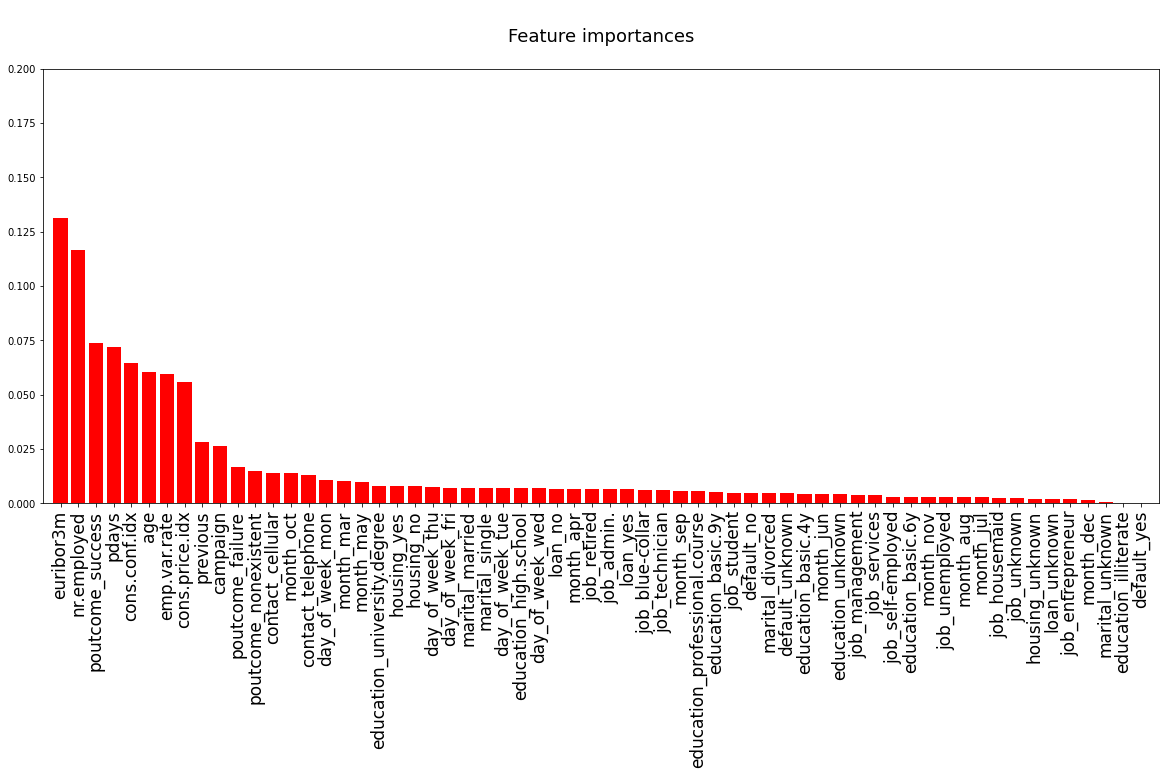

In [18]:
# Step 17: Evaluating the performance of the random forest classifier (part 4)

# Plotting the feature importance in random forest classifier
fig = plt.figure()       # create a figure object
plt.title("\nFeature importances\n", fontsize = 18)  # Add a title to the barchart
plt.bar(range(x_dataset_bank_dummies_dropdur_yno.shape[1]), importances[indices], color="r", align="center")  # Create a barchart with the specified parameters.
plt.xticks(range(x_dataset_bank_dummies_dropdur_yno.shape[1]), np.array(features)[indices], rotation=90, fontsize=17)   # This X-Axis property allows us to customize the values of X-axis
plt.xlim([-1, x_dataset_bank_dummies_dropdur_yno.shape[1]])   # This X-Axis property allows us to start the bar chart with an space on x-axis (better presentation)
fig.set_size_inches(20,8)             # This parameter is used to adjust the size of the bar chart.
axes = plt.gca()                      # get current axes
axes.set_ylim([0,.200])               # This Y-Axis property indicates: "Start at 0, finish at .200"

plt.show()   # Display the current figure that we are working on

As we can see above, the **top 3 features are**:
1. euribor3m (0.187778): euribor 3 month rate
2. pdays (0.168440): number of days that passed by after the client was last contacted from a previous campaign
3. nr.employed (0.148422): number of employees

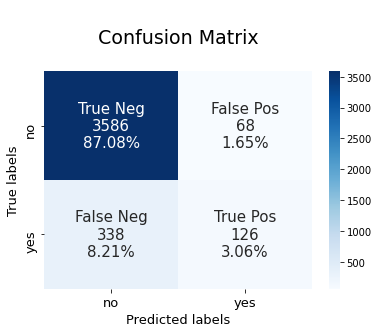

In [19]:
# Step 17: Evaluating the performance of the random forest classifier (part 5)

# Plotting the confusion matrix
cf_matrix = confusion_matrix(y_test, y_predict)        # create a confusion matrix object

group_names = ['True Neg','False Pos','False Neg','True Pos']   # Create string labels for each quadrant 
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]    # Output: 1 Array containing the total values for each quadrant
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]   # Output: 1 array containing the percentage values for each quadrant
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)] # Return the first element of each list, then the second element of each list, etc. This is a trick to consider the three lists as key and data to create a dictionary.
labels = np.asarray(labels).reshape(2,2)      # Convert the dictionary created before to an array. After that, the array is reshaped to 2-Dimension

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', annot_kws={"size":15})  # Create a heatmap chart with the specified parameters.

# labels, title and ticks
ax= plt.subplot()                                      # This function allows us to customize the X-axis and Y-axis of the figure
ax.set_title('\nConfusion Matrix\n', fontsize = 19)    # Add a title to the heatmap chart
ax.set_xlabel('Predicted labels', fontsize = 13)       # This X-Axis property allows us to customize the labels of X-axis
ax.set_ylabel('True labels', fontsize = 13)            # This Y-Axis property allows us to customize the labels of Y-axis
ax.xaxis.set_ticklabels(['no', 'yes'], fontsize = 13)  # This X-Axis property allows us to customize the values of X-axis
ax.yaxis.set_ticklabels(['no', 'yes'], fontsize = 13)  # This X-Axis property allows us to customize the values of Y-axis

plt.show()  # Display the current figure that we are working on

# np.flatten        This function is used to return a copy of the array collapsed into one dimension
# zip()             This function is used to merge 2 or more lists together. 
# np.asarray        This function is used to convert a given input to an array.
# .reshape          This function is used to give a new shape to an array without changing its data